In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.explain import GNNExplainer

import matplotlib.pyplot as plt


D:\zoonotic-radar\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# File paths and configuration
DATA_CSV = "master_feature_table_v2.csv"
MODEL_PATH = "gnn_species_risk_model.pt"
EDGE_LIST_NPY = "edge_index.npy"
EDGE_LIST_CSV = "edge_list.csv"

USE_KNN_IF_NO_EDGELIST = True
K_NEIGHBORS = 8
EXPLAINER_EPOCHS = 200
EXPLAINER_HOPS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")


Using device: cpu


In [3]:
df = pd.read_csv(DATA_CSV)
assert "species_name" in df.columns, "CSV must contain 'species_name'"
assert "high_risk_label" in df.columns, "CSV must contain 'high_risk_label'"

feature_cols = [c for c in df.columns if c not in ("species_name", "high_risk_label")]
X = df[feature_cols].fillna(0).values
y = df["high_risk_label"].astype(int).values
species = df["species_name"].astype(str).values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Loaded dataset: {df.shape[0]} species, {len(feature_cols)} features.")


Loaded dataset: 6153 species, 17 features.


In [5]:
# Function to try loading an edge index from pre-saved files
def try_load_edge_index():
    if os.path.exists(EDGE_LIST_NPY):
        arr = np.load(EDGE_LIST_NPY)
        if arr.shape[0] == 2:
            return torch.tensor(arr, dtype=torch.long)
        elif arr.shape[1] == 2:
            return torch.tensor(arr.T, dtype=torch.long)
    # If .npy not found, try loading from a CSV file
    if os.path.exists(EDGE_LIST_CSV):
        el = pd.read_csv(EDGE_LIST_CSV)
        src = el.iloc[:, 0].astype(int).values
        dst = el.iloc[:, 1].astype(int).values
        return torch.tensor(np.vstack([src, dst]), dtype=torch.long)
    return None

edge_index = try_load_edge_index()

# Load or construct edge_index

if edge_index is None and USE_KNN_IF_NO_EDGELIST:
    sim = cosine_similarity(X_scaled)
    np.fill_diagonal(sim, 0.0)
    edges = []
    for i in range(sim.shape[0]):
        top_k = np.argsort(sim[i])[-K_NEIGHBORS:]
        for j in top_k:
            edges.append([i, j])
            edges.append([j, i])
    edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)
    print(f"Built kNN graph: {edge_index.shape[1]} edges.")
else:
    print(f"Loaded graph with {edge_index.shape[1]} edges.")

# Create PyTorch Geometric Data object
data = Data(
    x=torch.tensor(X_scaled, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(y, dtype=torch.long)
)


Built kNN graph: 98448 edges.


### Define and Load GNN Model
We define a 2-layer GraphSAGE model for node classification.  
The model is then loaded with pre-trained weights from `gnn_species_risk_model.pt`.


In [7]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

#  GNN CLASS 
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

   
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GNN(in_channels=data.num_node_features, hidden_channels=64, out_channels=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model = model.to(DEVICE)
model.eval()

print(" Model re-defined and weights re-loaded.")


 Model re-defined and weights re-loaded.


In [8]:
# Move Data to Same Device
data = data.to(DEVICE)

# Run Inference
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    probs = torch.exp(logits)
    high_risk_probs = probs[:, 1].cpu().numpy()

# Save Results
node_scores_df = pd.DataFrame({
    "species_name": species,
    "node_index": np.arange(len(species)),
    "high_risk_prob": high_risk_probs,
    "pred_label": (high_risk_probs >= 0.5).astype(int)
}).sort_values("high_risk_prob", ascending=False)

node_scores_df.to_csv("node_risk_scores.csv", index=False)
print(" Saved node_risk_scores.csv")


 Saved node_risk_scores.csv


### Model Explanation Using GNNExplainer
We use `GNNExplainer` to understand which features and edges are most influential in predicting high-risk species.  
- Explanations are run on the top 50 predicted high-risk nodes.
- Feature and edge importances are aggregated for analysis.


In [9]:
# GNNExplainer setup (compatible with PyG ≥ 2.3)
try:
    explainer = GNNExplainer(model) 
except TypeError:
    # fallback for older versions that accept epochs in constructor
    explainer = GNNExplainer(model, epochs=EXPLAINER_EPOCHS)

edge_mask_accum = {}
feature_mask_accum = np.zeros(data.num_node_features, dtype=float)
counts_feature_masks = 0

global_edges = data.edge_index.cpu().numpy()
edge_lookup = {}
for i in range(global_edges.shape[1]):
    u, v = int(global_edges[0, i]), int(global_edges[1, i])
    edge_lookup.setdefault((u, v), []).append(i)

print("Starting GNNExplainer runs (may take time)...")


Starting GNNExplainer runs (may take time)...


In [10]:
from torch_geometric.explain import Explainer, GNNExplainer

# Initialize the GNN Explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=20),
    explanation_type='model',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    node_mask_type='attributes',
    edge_mask_type='object'
)


# Initialize accumulators for masks
edge_mask_accum = {}
feature_mask_accum = np.zeros(data.num_node_features, dtype=float)
counts_feature_masks = 0

print("Starting GNNExplainer runs (may take time)...")

high_risk_nodes = node_scores_df.query("pred_label == 1").head(50)["node_index"]

# Run Explainer for each high-risk node
for node_idx in high_risk_nodes:
    try:
        target_label = data.y[node_idx].unsqueeze(0)
        explanation = explainer(
            x=data.x,
            edge_index=data.edge_index,
            target=target_label,
            index=node_idx
        )
        node_feat_mask = explanation.get('node_feat_mask')
        edge_mask = explanation.get('edge_mask')
    except Exception as e:
        print(f"Explainer failed for node {node_idx}: {e}")
        continue

    # Accumulate feature importance
    if node_feat_mask is not None:
        feature_mask_accum += node_feat_mask.detach().cpu().numpy().flatten()
        counts_feature_masks += 1

    # Accumulate edge importance
    if edge_mask is not None:
        em = edge_mask.detach().cpu().numpy()
        for k in range(data.edge_index.shape[1]):
            u, v = int(data.edge_index[0, k]), int(data.edge_index[1, k])
            imp = float(em[k])
            edge_mask_accum[(u, v)] = edge_mask_accum.get((u, v), 0.0) + imp

print(" Explainer runs complete")

Starting GNNExplainer runs (may take time)...


D:\zoonotic-radar\.venv\Lib\site-packages\torch_geometric\explain\explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


 Explainer runs complete


In [11]:
edge_rows = [{"src": u, "dst": v, "importance": imp} for (u, v), imp in edge_mask_accum.items()]

if edge_rows:
    edge_scores_df = pd.DataFrame(edge_rows).sort_values("importance", ascending=False)
    edge_scores_df.to_csv("edge_risk_scores.csv", index=False)
    print(f" Saved edge_risk_scores.csv with {len(edge_scores_df)} edges.")
else:
    print(" No edge importances found — edge_mask_accum is empty. Skipping edge risk scoring.")

# Feature importance section
if counts_feature_masks > 0:
    avg_feature_mask = feature_mask_accum / counts_feature_masks
    feat_df = pd.DataFrame({
        "feature": feature_cols,
        "importance": avg_feature_mask
    }).sort_values("importance", ascending=False)
    feat_df.to_csv("feature_risk_drivers.csv", index=False)
    print(" Saved feature_risk_drivers.csv")
else:
    print(" No feature masks aggregated.")



 Saved edge_risk_scores.csv with 67378 edges.
 No feature masks aggregated.


In [12]:
# Check if 'edge_scores_df' exists in the current session and is not empty
if 'edge_scores_df' in globals() and not edge_scores_df.empty:
    
    # Merge source node information into edges
    edges_out = edge_scores_df.merge(
        node_scores_df[["node_index", "species_name", "high_risk_prob"]],
        left_on="src", right_on="node_index", how="left"
    ).rename(columns={"species_name": "src_species", "high_risk_prob": "src_high_risk_prob"}).drop(columns=["node_index"])

    # Merge destination node information into edges
    edges_out = edges_out.merge(
        node_scores_df[["node_index", "species_name", "high_risk_prob"]],
        left_on="dst", right_on="node_index", how="left"
    ).rename(columns={"species_name": "dst_species", "high_risk_prob": "dst_high_risk_prob"}).drop(columns=["node_index"])

    # Save the enriched edge data to a CSV file
    edges_out.to_csv("edge_risk_scores_enriched.csv", index=False)
    print(" Saved edge_risk_scores_enriched.csv")

    print("\nTop 10 high-risk species:")
    display(node_scores_df.head(10))

    print("\nTop 10 important edges:")
    display(edge_scores_df.head(10))
else:
    print(" edge_scores_df not defined or empty — skipping edge enrichment.")



 Saved edge_risk_scores_enriched.csv

Top 10 high-risk species:


,species_name,node_index,high_risk_prob,pred_label
365,Panthera leo,365,1.0,1
52,Panthera tigris,52,1.0,1
51,Panthera pardus,51,1.0,1
200,Ursus arctos,200,1.0,1
396,Puma concolor,396,1.0,1
340,Macaca mulatta,340,1.0,1
84,Acinonyx jubatus,84,1.0,1
338,Macaca fascicularis,338,1.0,1
132,Falco peregrinus,132,1.0,1
2414,Ursus americanus,2414,1.0,1



Top 10 important edges:


,src,dst,importance
4342,307,437,14.803538
5951,717,437,14.781661
3028,208,437,14.775344
5945,1355,437,14.763259
4330,306,437,14.763112
5949,707,437,14.755476
5947,1367,437,14.711158
5943,515,437,14.663882
1155,340,75,14.638724
5443,529,396,14.634918


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Define color palette for risk levels
risk_colors = {
    'critical': '#d32f2f',
    'high': '#f57c00',
    'moderate': '#fbc02d',
    'low': '#388e3c'
}

In [14]:
node_scores = pd.read_csv("node_risk_scores.csv")
edge_scores = pd.read_csv("edge_risk_scores.csv")

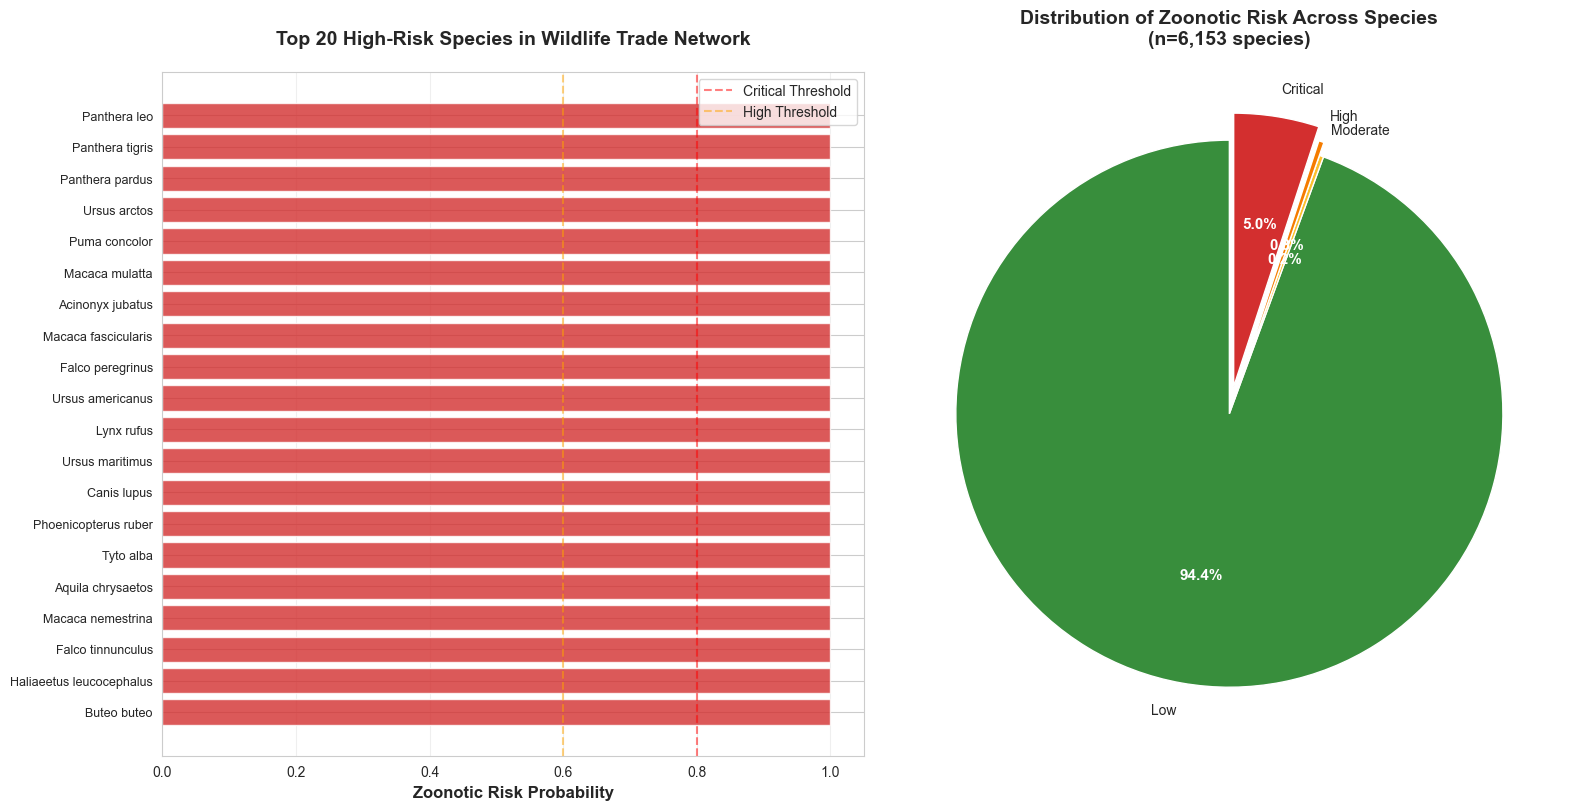


 Risk Distribution:
high_risk_prob
Low         5809
Moderate      15
High          19
Critical     310
Name: count, dtype: int64


In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top 20 high-risk species
top_species = node_scores.nlargest(20, 'high_risk_prob')

# Horizontal bar chart
colors = [risk_colors['critical'] if p >= 0.8 else
          risk_colors['high'] if p >= 0.6 else
          risk_colors['moderate'] for p in top_species['high_risk_prob']]

ax1.barh(range(len(top_species)), top_species['high_risk_prob'], color=colors, alpha=0.8)
ax1.set_yticks(range(len(top_species)))
ax1.set_yticklabels(top_species['species_name'], fontsize=9)
ax1.set_xlabel('Zoonotic Risk Probability', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 High-Risk Species in Wildlife Trade Network',
              fontsize=14, fontweight='bold', pad=20)
ax1.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='Critical Threshold')
ax1.axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='High Threshold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Risk distribution
risk_bins = pd.cut(node_scores['high_risk_prob'],
                   bins=[0, 0.4, 0.6, 0.8, 1.0],
                   labels=['Low', 'Moderate', 'High', 'Critical'])
risk_counts = risk_bins.value_counts().sort_index()

wedges, texts, autotexts = ax2.pie(risk_counts.values,
                                     labels=risk_counts.index,
                                     autopct='%1.1f%%',
                                     colors=[risk_colors['low'], risk_colors['moderate'],
                                            risk_colors['high'], risk_colors['critical']],
                                     startangle=90,
                                     explode=(0, 0, 0.05, 0.1))

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

ax2.set_title('Distribution of Zoonotic Risk Across Species\n(n=6,153 species)',
              fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('fig1_species_risk_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Risk Distribution:")
print(risk_counts)


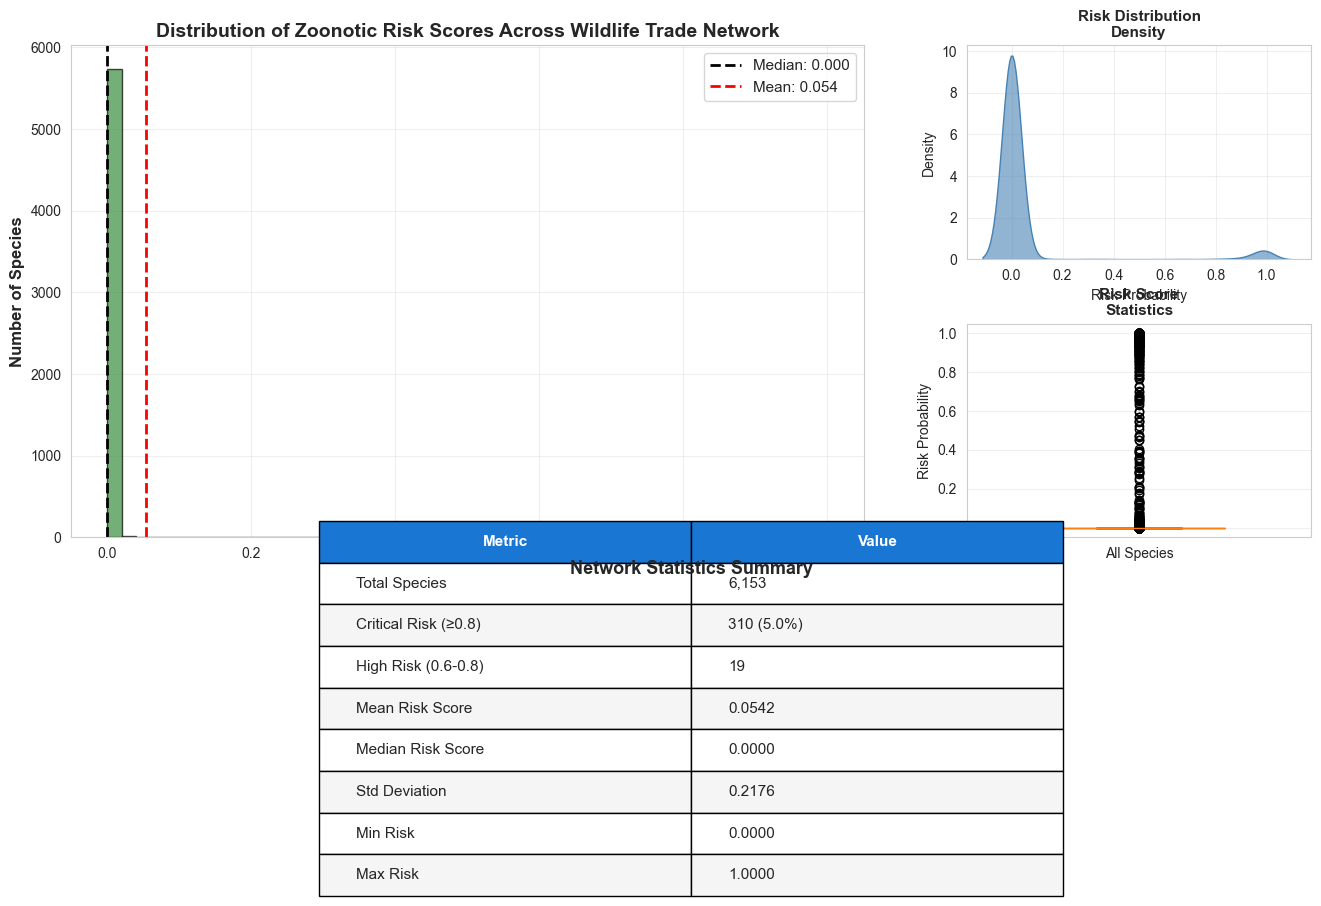

In [17]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Distribution histogram
ax1 = fig.add_subplot(gs[0:2, 0:2])
n, bins, patches = ax1.hist(node_scores['high_risk_prob'], bins=50,
                             color='steelblue', alpha=0.7, edgecolor='black')

# Color bars by risk level
for i, patch in enumerate(patches):
    if bins[i] >= 0.8:
        patch.set_facecolor(risk_colors['critical'])
    elif bins[i] >= 0.6:
        patch.set_facecolor(risk_colors['high'])
    elif bins[i] >= 0.4:
        patch.set_facecolor(risk_colors['moderate'])
    else:
        patch.set_facecolor(risk_colors['low'])

ax1.axvline(node_scores['high_risk_prob'].median(), color='black',
            linestyle='--', linewidth=2, label=f"Median: {node_scores['high_risk_prob'].median():.3f}")
ax1.axvline(node_scores['high_risk_prob'].mean(), color='red',
            linestyle='--', linewidth=2, label=f"Mean: {node_scores['high_risk_prob'].mean():.3f}")
ax1.set_xlabel('Zoonotic Risk Probability', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Species', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Zoonotic Risk Scores Across Wildlife Trade Network',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# KDE plot
ax2 = fig.add_subplot(gs[0, 2])
sns.kdeplot(data=node_scores['high_risk_prob'], ax=ax2, fill=True,
            color='steelblue', alpha=0.6)
ax2.set_xlabel('Risk Probability', fontsize=10)
ax2.set_ylabel('Density', fontsize=10)
ax2.set_title('Risk Distribution\nDensity', fontsize=11, fontweight='bold')
ax2.grid(alpha=0.3)

# Box plot
ax3 = fig.add_subplot(gs[1, 2])
bp = ax3.boxplot([node_scores['high_risk_prob']], vert=True, patch_artist=True,
                  widths=0.5)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
ax3.set_ylabel('Risk Probability', fontsize=10)
ax3.set_title('Risk Score\nStatistics', fontsize=11, fontweight='bold')
ax3.set_xticklabels(['All Species'])
ax3.grid(alpha=0.3)

# Statistics table
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

stats_data = [
    ['Total Species', f"{len(node_scores):,}"],
    ['Critical Risk (≥0.8)', f"{(node_scores['high_risk_prob'] >= 0.8).sum():,} ({(node_scores['high_risk_prob'] >= 0.8).sum()/len(node_scores)*100:.1f}%)"],
    ['High Risk (0.6-0.8)', f"{((node_scores['high_risk_prob'] >= 0.6) & (node_scores['high_risk_prob'] < 0.8)).sum():,}"],
    ['Mean Risk Score', f"{node_scores['high_risk_prob'].mean():.4f}"],
    ['Median Risk Score', f"{node_scores['high_risk_prob'].median():.4f}"],
    ['Std Deviation', f"{node_scores['high_risk_prob'].std():.4f}"],
    ['Min Risk', f"{node_scores['high_risk_prob'].min():.4f}"],
    ['Max Risk', f"{node_scores['high_risk_prob'].max():.4f}"]
]

table = ax4.table(cellText=stats_data, cellLoc='left',
                  colWidths=[0.3, 0.3], loc='center',
                  colLabels=['Metric', 'Value'])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style table
for i in range(len(stats_data) + 1):
    for j in range(2):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#1976d2')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#f5f5f5' if i % 2 == 0 else 'white')

ax4.set_title('Network Statistics Summary', fontsize=13, fontweight='bold', pad=20)

plt.savefig('fig4_risk_distribution_stats.png', dpi=300, bbox_inches='tight')
plt.show()


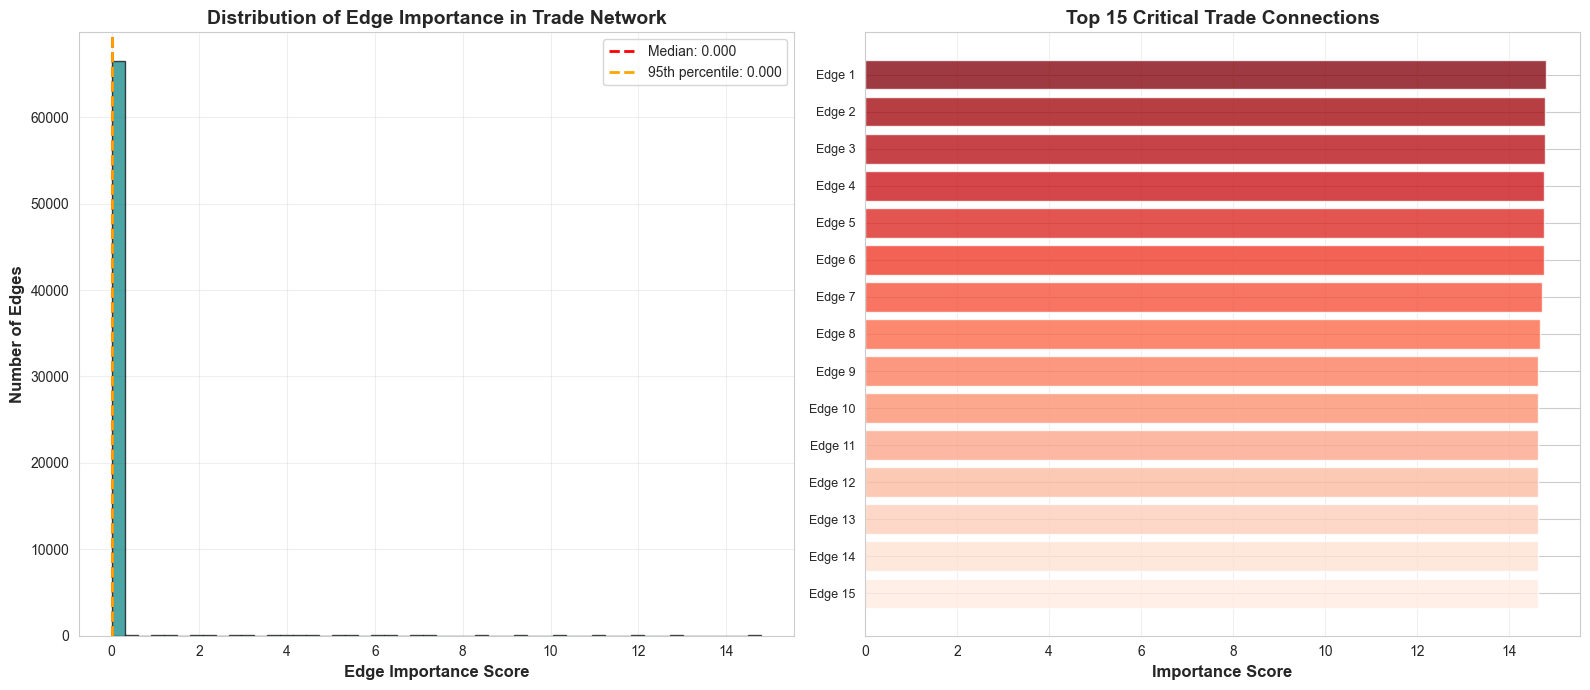


 Edge Statistics:
Total edges: 67,378
High importance edges (>0.7): 827
Mean importance: 0.0718


In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Edge importance distribution
ax1.hist(edge_scores['importance'], bins=50, color='teal', alpha=0.7, edgecolor='black')
ax1.axvline(edge_scores['importance'].median(), color='red',
            linestyle='--', linewidth=2, label=f"Median: {edge_scores['importance'].median():.3f}")
ax1.axvline(edge_scores['importance'].quantile(0.95), color='orange',
            linestyle='--', linewidth=2, label=f"95th percentile: {edge_scores['importance'].quantile(0.95):.3f}")
ax1.set_xlabel('Edge Importance Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Edges', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Edge Importance in Trade Network',
              fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Top edges bar chart
top_edges = edge_scores.nlargest(15, 'importance')
edge_labels = [f"{row['src']}-{row['dst']}" for _, row in top_edges.iterrows()]

ax2.barh(range(len(top_edges)), top_edges['importance'],
         color=sns.color_palette("Reds_r", len(top_edges)), alpha=0.8)
ax2.set_yticks(range(len(top_edges)))
ax2.set_yticklabels([f"Edge {i+1}" for i in range(len(top_edges))], fontsize=9)
ax2.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax2.set_title('Top 15 Critical Trade Connections', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('fig6_edge_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Edge Statistics:")
print(f"Total edges: {len(edge_scores):,}")
print(f"High importance edges (>0.7): {(edge_scores['importance'] > 0.7).sum():,}")
print(f"Mean importance: {edge_scores['importance'].mean():.4f}")
